In [74]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import skimage.measure
import math
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from sklearn.cluster import KMeans as KM
import scipy.cluster.hierarchy as sch


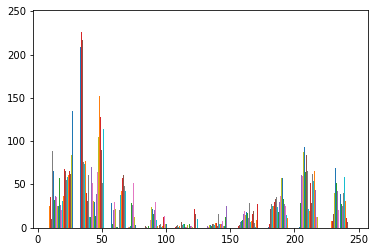

In [54]:
image=cv.imread('1.png')
img = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
hist = plt.hist(img)

## Simple Thresholding

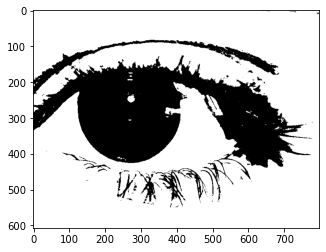

In [6]:
ret,th1 = cv.threshold(img,110,255,cv.THRESH_BINARY)
plt.imshow(th1, cmap ='gray')

we define a threshold based on the histogramme.

## Adaptative thresholding

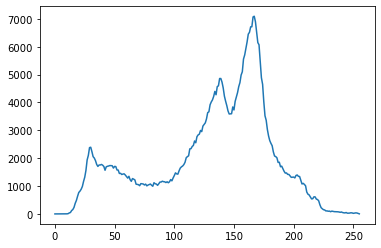

In [7]:
hist1,bins = np.histogram(img.ravel(),256,[0,256])
plt.plot(hist1)

In [65]:
# Theory behind l adaptive threshold
j=1
N= sum(hist1[i] for i in range(256))
T=np.zeros(256)
T[0]=sum(i* hist1[i] for i in range(256))/N

while(T[j-1] != T[j]):
    u1= (sum(i* hist1[i] for i in range(0, int(T[j])))) / (sum(hist1[i] for i in range(0, int(T[j]))) )
    u2= (sum(i* hist1[i] for i in range(int(T[j])+1, 256 ))) / (sum(hist1[i] for i in range(int(T[j])+1, 256)) )
    T[j]=(u1+u2)/2
    j=j+1



ZeroDivisionError: division by zero

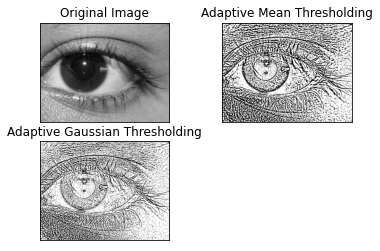

In [8]:
th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)
th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,2)
titles = ['Original Image', 'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [img, th2, th3]
for i in range(3):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

## it needs a filtering before applying the thresholding

## Color Thresholding

It can be interesting in case we treat different eyes colors, otherwise it's nto that interesting 

## Otsu Thresholding

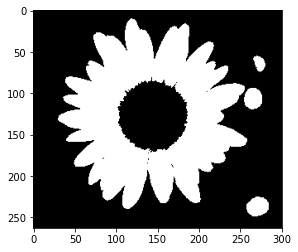

In [55]:
ret4,th4 = cv.threshold(img,0,255,cv.THRESH_BINARY + cv.THRESH_OTSU)
plt.imshow(th4, cmap='gray')
# diff = img * th4 
# plt.imshow(diff, cmap='gray')

## Connected Component Analysis

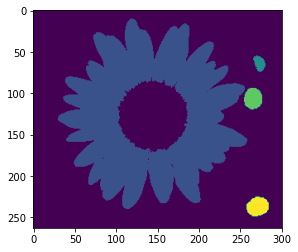

In [73]:
segmented_image, count = skimage.measure.label(th4,  return_num=True)
plt.imshow(segmented_image)

# object_features = skimage.measure.regionprops(segmented_image)
# object_areas = [objf["area"] for objf in object_features]

# fig, ax = plt.subplots()
# ax.imshow(image, cmap=plt.cm.gray)
# x0,y0= object_features[0].centroid

# orientation = object_features[0].orientation
# x1 = x0 + math.cos(orientation) * 0.5 * object_features[0].axis_minor_length
# y1 = y0 - math.sin(orientation) * 0.5 * object_features[0].axis_minor_length
# x2 = x0 - math.sin(orientation) * 0.5 * object_features[0].axis_major_length
# y2 = y0 - math.cos(orientation) * 0.5 * object_features[0].axis_major_length

# ax.plot((x0, x1), (y0, y1), '-r', linewidth=2.5)
# ax.plot((x0, x2), (y0, y2), '-r', linewidth=2.5)
# ax.plot(x0, y0, '.g', markersize=15)

# minr, minc, maxr, maxc = object_features[0].bbox
# bx = (minc, maxc, maxc, minc, minc)
# by = (minr, minr, maxr, maxr, minr)
# ax.plot(bx, by, '-b', linewidth=2.5)

## Region similarity (Watershed segmentation)

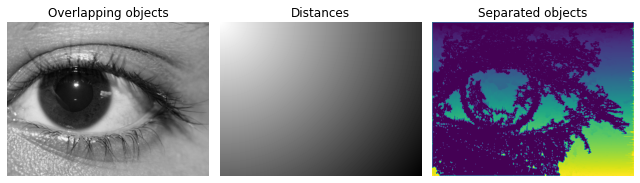

In [13]:
# Generate an initial image with two overlapping circles
# x, y = np.indices((80, 80))
# x1, y1, x2, y2 = 28, 28, 44, 52
# r1, r2 = 16, 20
# mask_circle1 = (x - x1)**2 + (y - y1)**2 < r1**2
# mask_circle2 = (x - x2)**2 + (y - y2)**2 < r2**2
# img = np.logical_or(mask_circle1, mask_circle2)

# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(img)
coords = peak_local_max(distance, footprint=np.ones((3, 3)), labels=img)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = watershed(-distance, markers, mask=img)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(img, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

## Clustering Based Segmentation 

## 1 - Kmeans

In [59]:
img1 = img.flatten()
img1 = img.reshape((-1, 1))
img1_32 = np.float32(img1)


In [94]:
k_means = KM(n_clusters=100).fit(img1)     
nb_clusts = k_means.n_clusters     

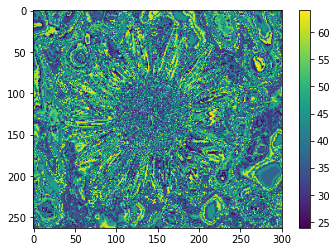

In [91]:
# convert all pixels to the color of the centroids
segmented_image = img1_32[k_means.labels_]
# reshape back to the original image dimension
segmented_image1 = segmented_image.reshape(img.shape)

plt.imshow(segmented_image1)
plt.colorbar()
plt.show()

## 2- Hierarchique

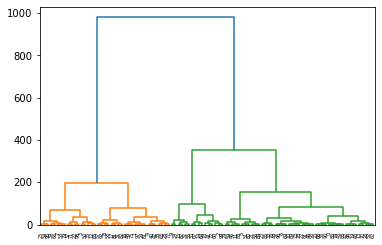

In [95]:
centroids_after_kmeans = k_means.cluster_centers_
heyhey= sch.linkage(centroids_after_kmeans, method='ward')
dendro=sch.dendrogram(heyhey)

In [99]:
cluster_index= [[] for j in range(nb_clusts)]

for i in range(img1.shape[0]):
    for j in range(nb_clusts):
        if k_means.labels_[i] == j:
            cluster_index[j].append(i)
            
print(cluster_index[8])

In [105]:
final_clusters = sch.fcluster(heyhey,5,criterion='maxclust')
print(final_clusters)

clustLL=[[] for j in range(5)]

# for j in range(5):
#     for i in range(segmented.shape[0]):
#         if (final_clusters[i]-1==j):
#             clustLL[j].extend(cluster_index[i])


for i in range(img1.shape[0]):
    for j in range(5):
        if segmented_image[i]=



[5 2 3 1 2 4 5 1 2 3 5 4 1 5 3 3 2 2 3 5 5 4 5 5 2 1 5 1 2 4 3 2 3 5 3 1 5
 1 2 1 2 3 5 5 5 5 4 2 2 5 1 4 5 1 1 3 4 2 2 4 3 2 5 2 3 1 1 3 5 5 5 1 3 5
 5 2 5 2 5 1 4 2 2 4 4 5 5 3 5 5 5 5 2 5 5 1 5 2 1 3]


In [98]:
seg_img= segmented_image[final_clusters]

AttributeError: 'numpy.ndarray' object has no attribute 'labels_'